In [1]:
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

import torchvision.datasets as dset

from torch.nn import init
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

NUM_TRAIN = 50000

NOISE_DIM = 96
BATCH_SIZE = 1024

dtype = torch.cuda.FloatTensor

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return


def discriminator_loss(real_scores, fake_scores):
    N = fake_scores.size(0)
    true_labels = Variable(torch.ones(N)).type(dtype)
    false_labels = Variable(torch.zeros(N)).type(dtype)
    loss = bce_loss(real_scores, true_labels) + bce_loss(fake_scores, false_labels)
    return loss


def bce_loss(input, target):
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()


def generator_loss(fake_scores):
    true_labels = Variable(torch.ones(fake_scores.size(0))).type(dtype)
    loss = bce_loss(fake_scores, true_labels)
    return loss


def get_optimizer(model, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    return optimizer


def sample_noise(batch_size, noise_dim):
    return 2 * torch.rand(batch_size, noise_dim) - 1


def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

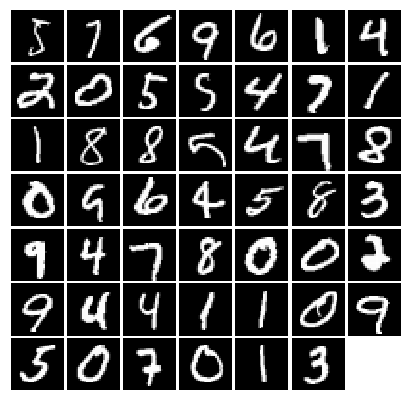

In [3]:
mnist_train = dset.MNIST('/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)

imgs = next(iter(loader_train))[0].view(BATCH_SIZE, 784).numpy()[:48, :].squeeze()
show_images(imgs)

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(-1, C*H*W)

    
class Unflatten(nn.Module):
    def __init__(self, N, C, H, W):
        super().__init__()
        self.size = (N, C, H, W)
        
    def forward(self, x):
        return x.view(*self.size)

    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, stride=2),
            Flatten(),
            nn.Linear(3*3*128, 2048),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 1),
        )
    
    def forward(self, x):
        output = self.main(x)
        return output


class Generator(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM):
        super().__init__()
        self.main = nn.Sequential(         
            nn.Linear(noise_dim, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 7*7*128),
            nn.ReLU(),
            nn.BatchNorm1d(7*7*128),
            Unflatten(-1, 128, 7, 7),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        output = self.main(x)
        return output

In [5]:
def run_gan(loader_train, D, G, D_solver, G_solver, D_loss, G_loss, show_all=False,
            show_every=200, batch_size=BATCH_SIZE, noise_dim=NOISE_DIM, num_epochs=10):
    iterations = 0
    for epoch in range(1, 1 + num_epochs):
        print('Epoch: %3d / %3d' % (epoch, num_epochs))
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            # Normalize real images  
            real_images = Variable(x).type(dtype)
            
            # Discriminate real images
            real_scores = D.forward(2 * (real_images - 0.5)).type(dtype)

            # Generate fake images
            fake_seed = Variable(sample_noise(batch_size, noise_dim)).type(dtype)
            fake_images = G.forward(fake_seed).detach()
            
            # Discriminate fake images
            fake_scores = D.forward(fake_images)
            
            # Optimize discriminator
            D_solver.zero_grad()
            d_error = D_loss(real_scores, fake_scores)
            d_error.backward()
            D_solver.step()
            
            # Generate fake images
            fake_seed = Variable(sample_noise(batch_size, noise_dim)).type(dtype)
            fake_images = G.forward(fake_seed)
            
            # Discriminate fake images with better discriminator
            fake_scores = D.forward(fake_images)
            
            # Optimize generator
            G_solver.zero_grad()
            g_error = G_loss(fake_scores)
            g_error.backward()
            G_solver.step()

            progress = iterations % show_every
            if progress == 0:
                print()
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iterations,d_error.data[0],g_error.data[0]))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                start = time.time()
            elif show_all:
                end = time.time()
                elapsed = end - start
                percent = 10.0 * progress / show_every
                eta = int((10-percent) * elapsed / percent)
                percent = int(percent)
                
                sys.stdout.flush()
                sys.stdout.write(
                    '-'*percent+'>'+\
                    ' '*(10-percent)+\
                    '| D_ERROR: %5.2f G_ERROR: %5.2f ETA: %d s\r' % (d_error.data[0], g_error.data[0],eta))
            iterations += 1
        print('D_ERROR: %5.2f G_ERROR: %5.2f' % (d_error.data[0], g_error.data[0]))

Epoch:   1 / 200

Iter: 0, D: 1.387, G:0.6606


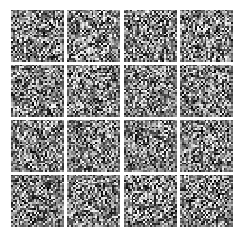

D_ERROR:  0.17 G_ERROR:  4.86
Epoch:   2 / 200
D_ERROR:  0.19 G_ERROR:  5.62
Epoch:   3 / 200
D_ERROR:  0.31 G_ERROR:  4.14
Epoch:   4 / 200
D_ERROR:  0.55 G_ERROR:  2.42
Epoch:   5 / 200
D_ERROR:  0.47 G_ERROR:  2.82
Epoch:   6 / 200
D_ERROR:  0.55 G_ERROR:  2.68
Epoch:   7 / 200

Iter: 400, D: 0.5588, G:1.96


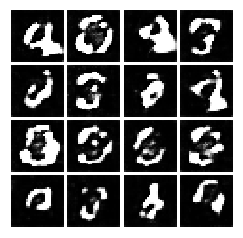

D_ERROR:  0.54 G_ERROR:  2.60
Epoch:   8 / 200
D_ERROR:  0.57 G_ERROR:  1.76
Epoch:   9 / 200
D_ERROR:  0.64 G_ERROR:  1.66
Epoch:  10 / 200
D_ERROR:  0.74 G_ERROR:  1.72
Epoch:  11 / 200
D_ERROR:  0.78 G_ERROR:  1.14
Epoch:  12 / 200
D_ERROR:  0.80 G_ERROR:  1.47
Epoch:  13 / 200
D_ERROR:  0.82 G_ERROR:  1.40
Epoch:  14 / 200

Iter: 800, D: 0.8191, G:1.218


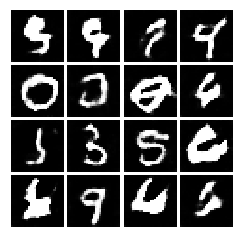

D_ERROR:  0.88 G_ERROR:  1.54
Epoch:  15 / 200
D_ERROR:  0.94 G_ERROR:  0.85
Epoch:  16 / 200
D_ERROR:  0.94 G_ERROR:  0.93
Epoch:  17 / 200
D_ERROR:  0.98 G_ERROR:  1.36
Epoch:  18 / 200
D_ERROR:  0.99 G_ERROR:  1.38
Epoch:  19 / 200
D_ERROR:  1.03 G_ERROR:  0.76
Epoch:  20 / 200
D_ERROR:  1.03 G_ERROR:  1.04
Epoch:  21 / 200

Iter: 1200, D: 1.074, G:0.9805


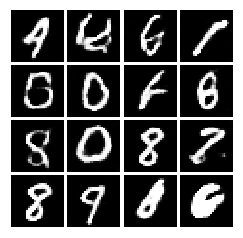

D_ERROR:  1.18 G_ERROR:  1.00
Epoch:  22 / 200
D_ERROR:  1.06 G_ERROR:  0.90
Epoch:  23 / 200
D_ERROR:  1.20 G_ERROR:  0.73
Epoch:  24 / 200
D_ERROR:  1.25 G_ERROR:  1.20
Epoch:  25 / 200
D_ERROR:  1.07 G_ERROR:  0.93
Epoch:  26 / 200
D_ERROR:  1.13 G_ERROR:  1.14
Epoch:  27 / 200
D_ERROR:  1.13 G_ERROR:  0.88
Epoch:  28 / 200

Iter: 1600, D: 1.111, G:0.8965


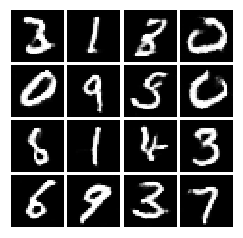

D_ERROR:  1.26 G_ERROR:  0.91
Epoch:  29 / 200
D_ERROR:  1.20 G_ERROR:  0.66
Epoch:  30 / 200
D_ERROR:  1.20 G_ERROR:  0.84
Epoch:  31 / 200
D_ERROR:  1.57 G_ERROR:  2.32
Epoch:  32 / 200
D_ERROR:  1.14 G_ERROR:  1.04
Epoch:  33 / 200
D_ERROR:  1.13 G_ERROR:  0.89
Epoch:  34 / 200
D_ERROR:  1.14 G_ERROR:  0.89
Epoch:  35 / 200

Iter: 2000, D: 1.142, G:0.8766


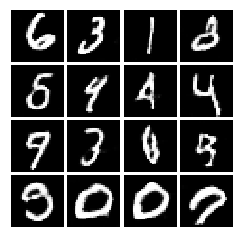

D_ERROR:  1.13 G_ERROR:  1.07
Epoch:  36 / 200
D_ERROR:  1.16 G_ERROR:  0.63
Epoch:  37 / 200
D_ERROR:  1.16 G_ERROR:  0.74
Epoch:  38 / 200
D_ERROR:  1.11 G_ERROR:  1.23
Epoch:  39 / 200
D_ERROR:  1.13 G_ERROR:  1.12
Epoch:  40 / 200
D_ERROR:  1.20 G_ERROR:  1.05
Epoch:  41 / 200
D_ERROR:  1.27 G_ERROR:  0.44
Epoch:  42 / 200

Iter: 2400, D: 1.178, G:0.9862


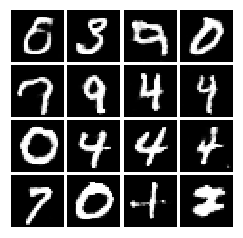

D_ERROR:  1.12 G_ERROR:  0.80
Epoch:  43 / 200
D_ERROR:  1.13 G_ERROR:  0.99
Epoch:  44 / 200
D_ERROR:  2.36 G_ERROR:  0.86
Epoch:  45 / 200
D_ERROR:  1.14 G_ERROR:  1.08
Epoch:  46 / 200
D_ERROR:  1.15 G_ERROR:  0.77
Epoch:  47 / 200
D_ERROR:  1.19 G_ERROR:  1.11
Epoch:  48 / 200
D_ERROR:  1.16 G_ERROR:  0.83
Epoch:  49 / 200

Iter: 2800, D: 1.123, G:0.914


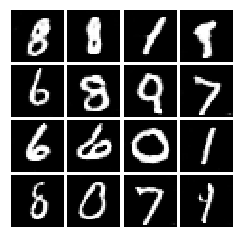

D_ERROR:  1.11 G_ERROR:  0.97
Epoch:  50 / 200
D_ERROR:  1.22 G_ERROR:  0.90
Epoch:  51 / 200
D_ERROR:  1.18 G_ERROR:  0.75
Epoch:  52 / 200
D_ERROR:  1.40 G_ERROR:  2.17
Epoch:  53 / 200
D_ERROR:  1.12 G_ERROR:  1.04
Epoch:  54 / 200
D_ERROR:  1.23 G_ERROR:  0.69
Epoch:  55 / 200
D_ERROR:  1.13 G_ERROR:  1.20
Epoch:  56 / 200

Iter: 3200, D: 1.1, G:0.8311


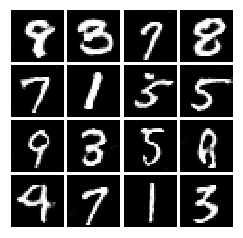

D_ERROR:  1.31 G_ERROR:  1.95
Epoch:  57 / 200
D_ERROR:  1.13 G_ERROR:  0.97
Epoch:  58 / 200
D_ERROR:  1.09 G_ERROR:  0.68
Epoch:  59 / 200
D_ERROR:  1.12 G_ERROR:  0.83
Epoch:  60 / 200
D_ERROR:  1.11 G_ERROR:  1.14
Epoch:  61 / 200
D_ERROR:  1.21 G_ERROR:  1.53
Epoch:  62 / 200
D_ERROR:  1.14 G_ERROR:  1.35
Epoch:  63 / 200

Iter: 3600, D: 1.08, G:1.046


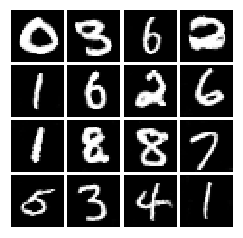

D_ERROR:  1.06 G_ERROR:  0.94
Epoch:  64 / 200
D_ERROR:  1.07 G_ERROR:  1.17
Epoch:  65 / 200
D_ERROR:  1.10 G_ERROR:  0.91
Epoch:  66 / 200
D_ERROR:  1.04 G_ERROR:  1.13
Epoch:  67 / 200
D_ERROR:  1.07 G_ERROR:  0.91
Epoch:  68 / 200
D_ERROR:  1.29 G_ERROR:  0.57
Epoch:  69 / 200

Iter: 4000, D: 1.129, G:1.703


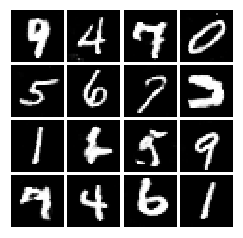

D_ERROR:  1.26 G_ERROR:  0.64
Epoch:  70 / 200
D_ERROR:  1.19 G_ERROR:  0.61
Epoch:  71 / 200
D_ERROR:  1.05 G_ERROR:  1.07
Epoch:  72 / 200
D_ERROR:  1.09 G_ERROR:  1.52
Epoch:  73 / 200
D_ERROR:  1.04 G_ERROR:  1.02
Epoch:  74 / 200
D_ERROR:  1.17 G_ERROR:  1.08
Epoch:  75 / 200
D_ERROR:  1.08 G_ERROR:  0.84
Epoch:  76 / 200

Iter: 4400, D: 1.331, G:0.6917


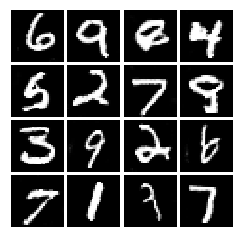

D_ERROR:  1.19 G_ERROR:  0.66
Epoch:  77 / 200
D_ERROR:  1.24 G_ERROR:  0.51
Epoch:  78 / 200
D_ERROR:  1.05 G_ERROR:  1.36
Epoch:  79 / 200
D_ERROR:  1.03 G_ERROR:  1.34
Epoch:  80 / 200
D_ERROR:  1.05 G_ERROR:  1.11
Epoch:  81 / 200
D_ERROR:  1.14 G_ERROR:  0.58
Epoch:  82 / 200
D_ERROR:  1.20 G_ERROR:  0.64
Epoch:  83 / 200

Iter: 4800, D: 1.399, G:0.6549


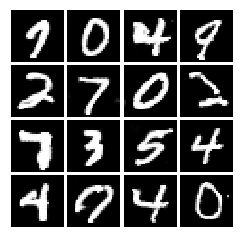

D_ERROR:  1.35 G_ERROR:  2.64
Epoch:  84 / 200
D_ERROR:  1.01 G_ERROR:  1.03
Epoch:  85 / 200
D_ERROR:  1.10 G_ERROR:  1.30
Epoch:  86 / 200
D_ERROR:  1.09 G_ERROR:  1.08
Epoch:  87 / 200
D_ERROR:  1.04 G_ERROR:  1.19
Epoch:  88 / 200
D_ERROR:  1.02 G_ERROR:  1.34
Epoch:  89 / 200
D_ERROR:  1.14 G_ERROR:  1.92
Epoch:  90 / 200

Iter: 5200, D: 1.289, G:0.6821


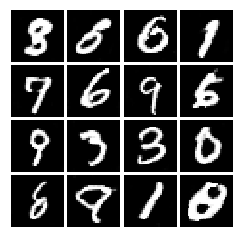

D_ERROR:  1.15 G_ERROR:  0.77
Epoch:  91 / 200
D_ERROR:  1.10 G_ERROR:  1.66
Epoch:  92 / 200
D_ERROR:  1.01 G_ERROR:  1.29
Epoch:  93 / 200
D_ERROR:  1.05 G_ERROR:  1.11
Epoch:  94 / 200
D_ERROR:  1.00 G_ERROR:  1.36
Epoch:  95 / 200
D_ERROR:  1.01 G_ERROR:  1.31
Epoch:  96 / 200
D_ERROR:  0.99 G_ERROR:  1.17
Epoch:  97 / 200

Iter: 5600, D: 0.9931, G:1.333


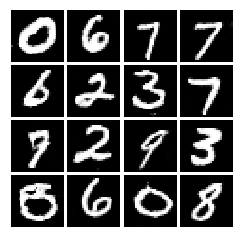

D_ERROR:  1.06 G_ERROR:  1.00
Epoch:  98 / 200
D_ERROR:  1.29 G_ERROR:  0.95
Epoch:  99 / 200
D_ERROR:  0.99 G_ERROR:  2.07
Epoch: 100 / 200
D_ERROR:  1.04 G_ERROR:  1.00
Epoch: 101 / 200
D_ERROR:  1.04 G_ERROR:  1.11
Epoch: 102 / 200
D_ERROR:  1.00 G_ERROR:  1.40
Epoch: 103 / 200
D_ERROR:  0.96 G_ERROR:  1.35
Epoch: 104 / 200

Iter: 6000, D: 1.112, G:1.666


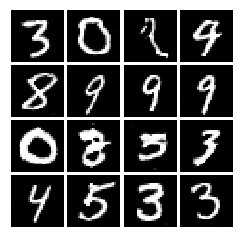

D_ERROR:  1.06 G_ERROR:  1.02
Epoch: 105 / 200
D_ERROR:  1.13 G_ERROR:  1.47
Epoch: 106 / 200
D_ERROR:  1.03 G_ERROR:  1.41
Epoch: 107 / 200
D_ERROR:  1.13 G_ERROR:  0.85
Epoch: 108 / 200
D_ERROR:  0.96 G_ERROR:  1.10
Epoch: 109 / 200
D_ERROR:  1.09 G_ERROR:  0.95
Epoch: 110 / 200
D_ERROR:  1.00 G_ERROR:  1.56
Epoch: 111 / 200

Iter: 6400, D: 1.095, G:0.648


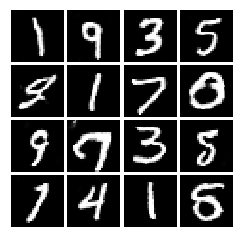

D_ERROR:  1.08 G_ERROR:  0.90
Epoch: 112 / 200
D_ERROR:  0.96 G_ERROR:  1.18
Epoch: 113 / 200
D_ERROR:  0.97 G_ERROR:  1.68
Epoch: 114 / 200
D_ERROR:  0.98 G_ERROR:  1.23
Epoch: 115 / 200
D_ERROR:  1.01 G_ERROR:  1.92
Epoch: 116 / 200
D_ERROR:  0.98 G_ERROR:  1.06
Epoch: 117 / 200
D_ERROR:  0.97 G_ERROR:  1.57
Epoch: 118 / 200

Iter: 6800, D: 1.061, G:1.591


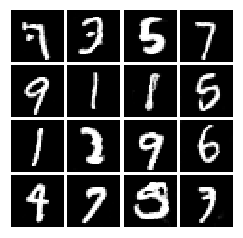

D_ERROR:  1.05 G_ERROR:  2.12
Epoch: 119 / 200
D_ERROR:  1.11 G_ERROR:  1.17
Epoch: 120 / 200
D_ERROR:  0.93 G_ERROR:  1.14
Epoch: 121 / 200
D_ERROR:  0.98 G_ERROR:  1.68
Epoch: 122 / 200
D_ERROR:  0.96 G_ERROR:  1.36
Epoch: 123 / 200
D_ERROR:  1.04 G_ERROR:  2.02
Epoch: 124 / 200
D_ERROR:  0.95 G_ERROR:  1.48
Epoch: 125 / 200

Iter: 7200, D: 1.065, G:1.087


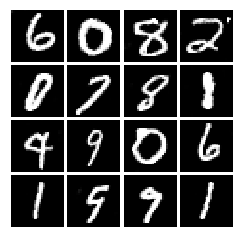

D_ERROR:  0.94 G_ERROR:  1.44
Epoch: 126 / 200
D_ERROR:  1.05 G_ERROR:  1.30
Epoch: 127 / 200
D_ERROR:  0.92 G_ERROR:  1.74
Epoch: 128 / 200
D_ERROR:  0.94 G_ERROR:  1.59
Epoch: 129 / 200
D_ERROR:  0.99 G_ERROR:  1.08
Epoch: 130 / 200
D_ERROR:  0.93 G_ERROR:  1.10
Epoch: 131 / 200
D_ERROR:  0.93 G_ERROR:  1.43
Epoch: 132 / 200

Iter: 7600, D: 0.9199, G:1.571


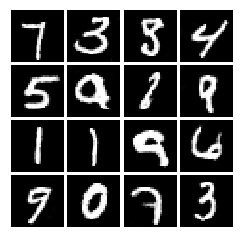

D_ERROR:  0.89 G_ERROR:  1.44
Epoch: 133 / 200
D_ERROR:  0.97 G_ERROR:  1.49
Epoch: 134 / 200
D_ERROR:  0.93 G_ERROR:  1.46
Epoch: 135 / 200
D_ERROR:  0.88 G_ERROR:  1.58
Epoch: 136 / 200
D_ERROR:  0.94 G_ERROR:  1.62
Epoch: 137 / 200
D_ERROR:  1.01 G_ERROR:  1.45
Epoch: 138 / 200

Iter: 8000, D: 1.047, G:0.9903


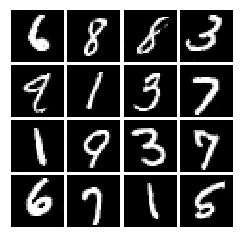

D_ERROR:  0.95 G_ERROR:  1.30
Epoch: 139 / 200
D_ERROR:  1.01 G_ERROR:  1.61
Epoch: 140 / 200
D_ERROR:  0.93 G_ERROR:  1.42
Epoch: 141 / 200
D_ERROR:  0.95 G_ERROR:  2.00
Epoch: 142 / 200
D_ERROR:  0.94 G_ERROR:  1.35
Epoch: 143 / 200
D_ERROR:  1.09 G_ERROR:  1.00
Epoch: 144 / 200
D_ERROR:  0.95 G_ERROR:  1.71
Epoch: 145 / 200

Iter: 8400, D: 0.9423, G:2.122


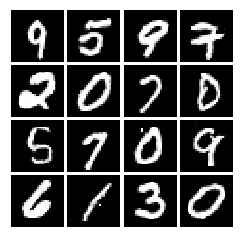

D_ERROR:  0.97 G_ERROR:  2.01
Epoch: 146 / 200
D_ERROR:  0.93 G_ERROR:  1.51
Epoch: 147 / 200
D_ERROR:  0.89 G_ERROR:  1.34
Epoch: 148 / 200
D_ERROR:  0.90 G_ERROR:  1.44
Epoch: 149 / 200
D_ERROR:  0.99 G_ERROR:  1.22
Epoch: 150 / 200
D_ERROR:  0.98 G_ERROR:  0.95
Epoch: 151 / 200
D_ERROR:  0.92 G_ERROR:  1.35
Epoch: 152 / 200

Iter: 8800, D: 0.9917, G:2.027


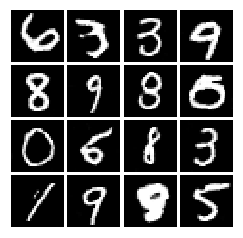

D_ERROR:  0.85 G_ERROR:  1.51
Epoch: 153 / 200
D_ERROR:  0.88 G_ERROR:  1.10
Epoch: 154 / 200
D_ERROR:  0.92 G_ERROR:  1.74
Epoch: 155 / 200
D_ERROR:  0.84 G_ERROR:  1.65
Epoch: 156 / 200
D_ERROR:  1.01 G_ERROR:  2.18
Epoch: 157 / 200
D_ERROR:  0.94 G_ERROR:  2.01
Epoch: 158 / 200
D_ERROR:  0.92 G_ERROR:  1.52
Epoch: 159 / 200

Iter: 9200, D: 0.858, G:1.915


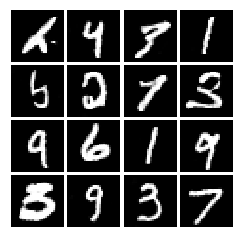

D_ERROR:  1.19 G_ERROR:  2.77
Epoch: 160 / 200
D_ERROR:  0.86 G_ERROR:  1.58
Epoch: 161 / 200


KeyboardInterrupt: 

In [6]:
D = Discriminator().type(dtype)
G = Generator().type(dtype)

D.apply(initialize_weights)
G.apply(initialize_weights)

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

run_gan(loader_train, D, G, D_solver, G_solver,
        discriminator_loss, generator_loss,
        show_every=400, num_epochs=200)   